In [49]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
dataset = read_csv('./data/VN30.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
# encoder = LabelEncoder()
# values[:,30] = encoder.fit_transform(values[:,30])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_days_lag = 20
n_features = len(dataset.columns)

reframed = series_to_supervised(scaled, n_days_lag, 1)
# drop columns we don't want to predict
# reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.head()

,var1(t-20),var2(t-20),var3(t-20),var4(t-20),var5(t-20),var6(t-20),var1(t-19),var2(t-19),var3(t-19),var4(t-19),...,var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t)
20,0.061293,0.063490,0.062134,0.063228,0.041940,0.606312,0.057632,0.062393,0.058679,0.060026,...,0.042798,0.041928,0.027541,0.717608,0.041681,0.049314,0.044215,0.045042,0.013422,0.495847
21,0.057632,0.062393,0.058679,0.060026,0.018958,0.491694,0.059011,0.061392,0.058478,0.059141,...,0.044215,0.045042,0.013422,0.495847,0.045580,0.041546,0.043655,0.041981,0.018818,0.633721
22,0.059011,0.061392,0.058478,0.059141,0.014236,0.584718,0.055899,0.059303,0.056266,0.059584,...,0.043655,0.041981,0.018818,0.633721,0.046526,0.049200,0.045571,0.048270,0.018725,0.577242
23,0.055899,0.059303,0.056266,0.059584,0.020237,0.501661,0.052035,0.058531,0.053091,0.055055,...,0.045571,0.048270,0.018725,0.577242,0.054033,0.049972,0.051683,0.049420,0.049244,0.701827
24,0.052035,0.058531,0.053091,0.055055,0.029798,0.486711,0.050046,0.054493,0.052540,0.052428,...,0.051683,0.049420,0.049244,0.701827,0.049462,0.061612,0.056388,0.053312,0.050361,0.473422


In [53]:
# split into train and test sets
n_obs = n_days_lag * n_features

values = reframed.values
n_train_days = int(len(reframed.index) * 0.8)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
# reshape input to be 3D [samples, timesteps, features]


In [55]:
train_X = train_X.reshape((train_X.shape[0], n_days_lag, n_features))
train_y = train_y[:, 0]
test_X = test_X.reshape((test_X.shape[0], n_days_lag, n_features))
test_y = test_y[:, 0]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2092, 20, 6) (2092,) (523, 20, 6) (523,)


Epoch 1/50


2023-05-02 21:18:06.045824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-02 21:18:06.048234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-02 21:18:06.049977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

22/22 - 5s - loss: 0.0487 - val_loss: 0.0416 - 5s/epoch - 205ms/step
Epoch 2/50
22/22 - 1s - loss: 0.0555 - val_loss: 0.0262 - 688ms/epoch - 31ms/step
Epoch 3/50
22/22 - 1s - loss: 0.0307 - val_loss: 0.0165 - 544ms/epoch - 25ms/step
Epoch 4/50
22/22 - 0s - loss: 0.0416 - val_loss: 0.0259 - 481ms/epoch - 22ms/step
Epoch 5/50
22/22 - 1s - loss: 0.0106 - val_loss: 0.0265 - 796ms/epoch - 36ms/step
Epoch 6/50
22/22 - 1s - loss: 0.0171 - val_loss: 0.0196 - 534ms/epoch - 24ms/step
Epoch 7/50
22/22 - 0s - loss: 0.0167 - val_loss: 0.0266 - 471ms/epoch - 21ms/step
Epoch 8/50
22/22 - 0s - loss: 0.0183 - val_loss: 0.0159 - 352ms/epoch - 16ms/step
Epoch 9/50
22/22 - 0s - loss: 0.0274 - val_loss: 0.0156 - 355ms/epoch - 16ms/step
Epoch 10/50
22/22 - 0s - loss: 0.0195 - val_loss: 0.0112 - 403ms/epoch - 18ms/step
Epoch 11/50
22/22 - 0s - loss: 0.0310 - val_loss: 0.0190 - 376ms/epoch - 17ms/step
Epoch 12/50
22/22 - 1s - loss: 0.0080 - val_loss: 0.0118 - 564ms/epoch - 26ms/step
Epoch 13/50
22/22 - 1s - l

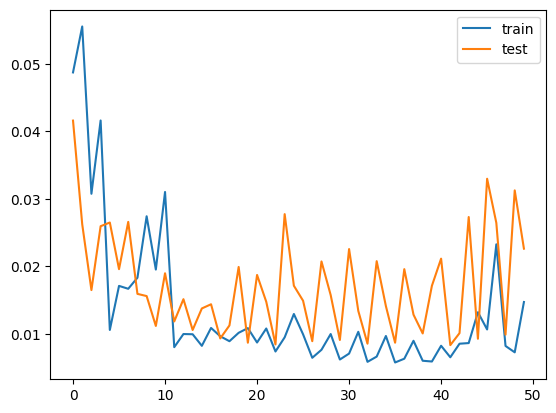

In [56]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
# history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_split=0.25, verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


In [57]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})
def adjust(val, length= 6): return str(val).ljust(length)


In [58]:
n_features

6

In [59]:
yhat = model.predict(test_X)
yhat.shape

2023-05-02 21:19:01.275849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-02 21:19:01.280294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-02 21:19:01.285281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

17/17 [==============================] - 1s 8ms/step


(523, 1)

In [60]:
yhat = model.predict(test_X)
test_X_base = test_X.reshape((test_X.shape[0], n_days_lag*n_features))
# invert scaling for forecast
inv_yhat = concatenate((test_X_base[:, -(n_features-1):], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat[:,0]

17/17 [==============================] - 0s 9ms/step


array([ 964.69867,  971.7175 ,  963.9542 ,  976.5621 ,  980.4338 ,
        986.1322 ,  984.48425,  992.188  ,  993.7763 , 1004.508  ,
        994.5011 , 1008.9158 , 1024.3431 , 1013.6809 , 1028.5425 ,
       1016.94714, 1037.8446 , 1050.9191 , 1053.6193 , 1045.7567 ,
       1033.7345 , 1053.103  , 1053.9569 , 1058.8909 , 1058.8512 ,
       1072.0348 , 1090.1724 , 1105.0934 , 1113.1744 , 1130.1702 ,
       1147.1067 , 1162.375  , 1168.0536 , 1164.1421 , 1168.1628 ,
       1182.0414 , 1172.1339 , 1108.2504 , 1115.4874 , 1150.3231 ,
       1155.535  , 1152.944  , 1122.1488 , 1080.3639 , 1010.0078 ,
       1047.782  , 1029.4558 , 1079.7683 , 1116.7881 , 1117.185  ,
       1134.6377 , 1092.1182 , 1129.366  , 1173.6527 , 1185.4664 ,
       1179.2914 , 1179.1921 , 1181.5549 , 1167.1204 , 1168.2621 ,
       1172.5806 , 1191.3236 , 1193.4878 , 1194.3217 , 1173.2158 ,
       1174.0398 , 1168.7783 , 1162.3652 , 1171.8062 , 1187.4916 ,
       1186.5981 , 1189.8146 , 1187.0647 , 1192.4255 , 1209.66

In [61]:
inv_y = concatenate((test_X_base, test_y), axis=1)
inv_y.shape

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [35]:
# test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X_base, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
inv_y

ValueError: operands could not be broadcast together with shapes (523,126) (6,) (523,126) 

In [10]:
# make a prediction
yhat = model.predict(test_X)
test_X_base = test_X.reshape((test_X.shape[0], n_days_lag*n_features))
# invert scaling for forecast
inv_yhat = concatenate((test_X_base[:, -(n_features-1):], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X_base[:, -(n_features-1):], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)
print('\nForecast Accuracy of: VN30')
accuracy_prod = forecast_accuracy(inv_yhat, inv_y)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

25/25 [==============================] - 0s 3ms/step

Forecast Accuracy of: VN30
mape   :  0.0
me     :  0.0
mae    :  0.0
mpe    :  0.0
rmse   :  0.0
corr   :  1.0
minmax :  0.0


In [ ]:
DataFrame({'pred': inv_yhat, 'true': inv_y})

,pred,true
0,23996.873047,23996.873047
1,23996.873047,23996.873047
2,24548.970703,24548.970703
3,24699.585938,24699.585938
4,25301.550781,25301.550781
...,...,...
443,18621.939453,18621.939453
444,18520.169922,18520.169922
445,18520.169922,18520.169922
446,18621.939453,18621.939453
